In [1]:
# !pip install pandas-datareader

In [2]:
import pandas as pd
import numpy as np
from multiprocessing import Pool
from math import log
from datetime import datetime
from datetime import datetime, date, time, timezone
from datetime_truncate import truncate

import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller as adf
from statsmodels.graphics.gofplots import qqplot
from pandas.plotting import register_matplotlib_converters
from pandas.plotting import autocorrelation_plot
from pandas_datareader import data
from scipy import stats

### Data preparation. Part 1

In [3]:
######## download data #########

df = pd.read_csv('/Users/k.dortsev/Desktop/btcusdt_5m.csv')
df['open_time'] = pd.to_datetime(df['open_time'], unit = 'ms')
df = df.set_index('open_time')
# d

In [4]:
######## some unnecessary columns ###########

columns_to_drop = ['open', 'high', 'low', 'volume', 'close_time', 'quote_vol',
       'trades', 'buy_vol', 'buy_q_vol', 'ignore']

df = df.drop(columns_to_drop, axis = 1)
df = df.dropna()
df.head(1000)

,close
open_time,
2018-11-06 04:30:00,6456.33
2018-11-06 04:35:00,6460.46
2018-11-06 04:40:00,6456.21
2018-11-06 04:45:00,6455.19
2018-11-06 04:50:00,6452.34
...,...
2018-11-09 15:25:00,6423.00
2018-11-09 15:30:00,6427.96
2018-11-09 15:35:00,6432.06


### Returns and Log RV

In [5]:
######## returns calculation #########

df = df.applymap(lambda x: np.log(x)) - df.applymap(lambda x: np.log(x)).shift(1)
df = df.rename(columns = {'close': 'returns'})
df = df.dropna()
df['sum_of_squares'] = df.returns**2

######## RV calculation #############

df['Realized_volatility'] = np.sqrt(df['sum_of_squares'] + (df['sum_of_squares']).shift(1))
df['Log_realized_volatility'] = np.log(np.sqrt(df['sum_of_squares'] + (df['sum_of_squares']).shift(1)))
df = df.dropna()
df

,returns,sum_of_squares,Realized_volatility,Log_realized_volatility
open_time,,,,
2018-11-06 04:40:00,-0.000658,4.330487e-07,0.000918,-6.993754
2018-11-06 04:45:00,-0.000158,2.496397e-08,0.000677,-7.298184
2018-11-06 04:50:00,-0.000442,1.950129e-07,0.000469,-7.664872
2018-11-06 04:55:00,0.000908,8.240745e-07,0.001009,-6.898302
2018-11-06 05:00:00,0.000683,4.659697e-07,0.001136,-6.780417
...,...,...,...,...
2022-11-03 12:05:00,0.000626,3.913309e-07,0.001210,-6.717522
2022-11-03 12:10:00,-0.001140,1.299150e-06,0.001300,-6.645249
2022-11-03 12:15:00,-0.000982,9.644332e-07,0.001505,-6.499281


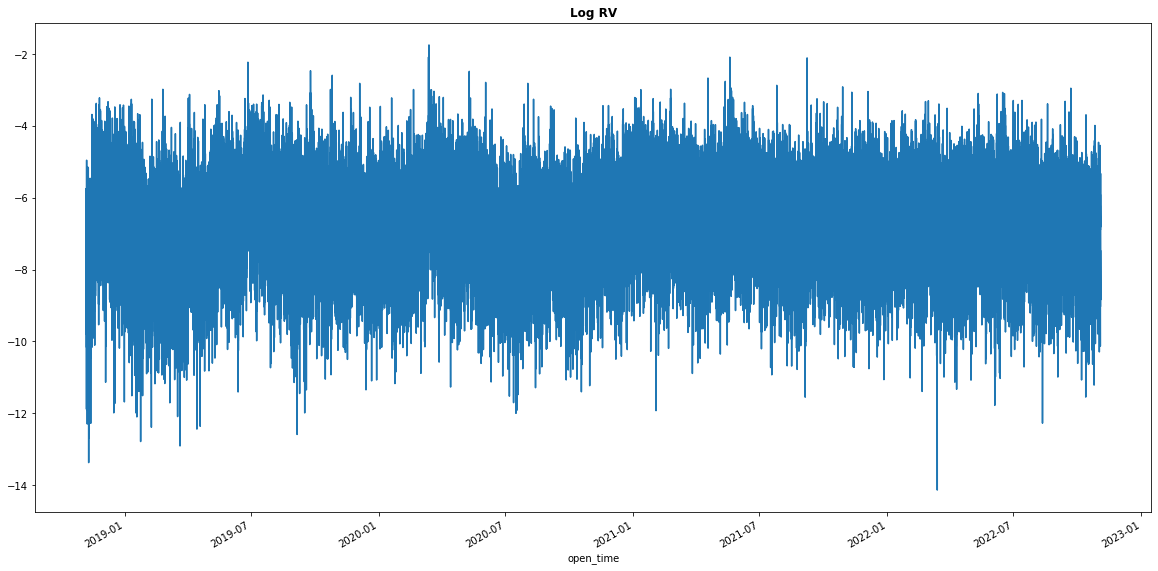

In [6]:
########### Log RV chart ############

df['Log_realized_volatility'].plot(figsize=(20, 10))
plt.title("Log RV", weight="bold")

plt.show()

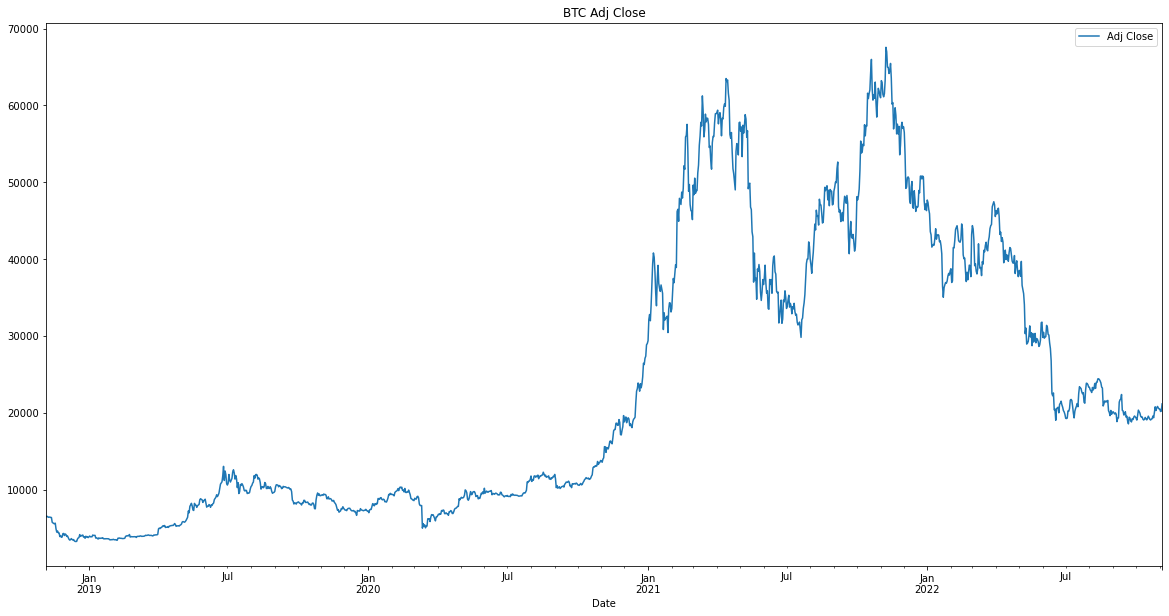

In [7]:
# Download BTC-USD adj close data from yahoo finance
start = str(df.index[0].date())
end = str(df.index[-1].date())

BTC_daily = data.DataReader("BTC-USD", start=start, end=end, data_source="yahoo")[["Adj Close"]]

BTC_daily.plot(title = "BTC Adj Close", figsize=(20, 10));plt.show()

### Data preparation. Part 2

In [8]:
############# Compute number of periods/day ##################
df["D"] = df.index.date
n_periods = df.pivot_table(index = ["D"], aggfunc = 'size').values

stats.describe(n_periods)

DescribeResult(nobs=1459, minmax=(150, 408), mean=287.8670322138451, variance=86.74225257166385, skewness=-2.900589545413869, kurtosis=101.2929978147812)

In [9]:
df

,returns,sum_of_squares,Realized_volatility,Log_realized_volatility,D
open_time,,,,,
2018-11-06 04:40:00,-0.000658,4.330487e-07,0.000918,-6.993754,2018-11-06
2018-11-06 04:45:00,-0.000158,2.496397e-08,0.000677,-7.298184,2018-11-06
2018-11-06 04:50:00,-0.000442,1.950129e-07,0.000469,-7.664872,2018-11-06
2018-11-06 04:55:00,0.000908,8.240745e-07,0.001009,-6.898302,2018-11-06
2018-11-06 05:00:00,0.000683,4.659697e-07,0.001136,-6.780417,2018-11-06
...,...,...,...,...,...
2022-11-03 12:05:00,0.000626,3.913309e-07,0.001210,-6.717522,2022-11-03
2022-11-03 12:10:00,-0.001140,1.299150e-06,0.001300,-6.645249,2022-11-03
2022-11-03 12:15:00,-0.000982,9.644332e-07,0.001505,-6.499281,2022-11-03


In [10]:
# Perform the sum grouped by days.
rv = df.groupby("D")["sum_of_squares"].agg(np.sum).to_frame()
rv

,sum_of_squares
D,
2018-11-06,0.000096
2018-11-07,0.000168
2018-11-08,0.000151
2018-11-09,0.000129
2018-11-10,0.000052
...,...
2022-10-30,0.000222
2022-10-31,0.000520
2022-11-01,0.000181


In [11]:
############## Getting daily RV ##################
rv['RV_daily'] = np.sqrt(rv['sum_of_squares'] + (rv['sum_of_squares']).shift(1))
rv = rv.dropna()
rv # check

,sum_of_squares,RV_daily
D,,
2018-11-07,0.000168,0.016269
2018-11-08,0.000151,0.017870
2018-11-09,0.000129,0.016724
2018-11-10,0.000052,0.013428
2018-11-11,0.000107,0.012597
...,...,...
2022-10-30,0.000222,0.024401
2022-10-31,0.000520,0.027236
2022-11-01,0.000181,0.026489


In [12]:
######## Compute weekly and monthly RV #############  
rv["RV_weekly"] = rv["RV_daily"].rolling(5).mean()
rv["RV_monthly"] = rv["RV_daily"].rolling(21).mean()
rv.dropna(inplace = True)
rv

,sum_of_squares,RV_daily,RV_weekly,RV_monthly
D,,,,
2018-11-27,0.003332,0.101891,0.101001,0.062445
2018-11-28,0.003982,0.085520,0.104299,0.065742
2018-11-29,0.003107,0.084195,0.103573,0.068901
2018-11-30,0.002984,0.078044,0.095444,0.071821
2018-12-01,0.001618,0.067842,0.083498,0.074412
...,...,...,...,...
2022-10-30,0.000222,0.024401,0.033322,0.027832
2022-10-31,0.000520,0.027236,0.030059,0.028019
2022-11-01,0.000181,0.026489,0.027320,0.028006


In [13]:
####### Getting log RV ##########

rv['Log_RV_daily'] = np.log(rv['RV_daily'])
rv['Log_RV_weekly'] = np.log(rv['RV_weekly'])
rv['Log_RV_monthly'] = np.log(rv['RV_monthly'])
rv #check

,sum_of_squares,RV_daily,RV_weekly,RV_monthly,Log_RV_daily,Log_RV_weekly,Log_RV_monthly
D,,,,,,,
2018-11-27,0.003332,0.101891,0.101001,0.062445,-2.283849,-2.292622,-2.773476
2018-11-28,0.003982,0.085520,0.104299,0.065742,-2.459004,-2.260498,-2.722013
2018-11-29,0.003107,0.084195,0.103573,0.068901,-2.474620,-2.267475,-2.675090
2018-11-30,0.002984,0.078044,0.095444,0.071821,-2.550484,-2.349215,-2.633584
2018-12-01,0.001618,0.067842,0.083498,0.074412,-2.690574,-2.482927,-2.598141
...,...,...,...,...,...,...,...
2022-10-30,0.000222,0.024401,0.033322,0.027832,-3.713146,-3.401543,-3.581556
2022-10-31,0.000520,0.027236,0.030059,0.028019,-3.603225,-3.504593,-3.574880
2022-11-01,0.000181,0.026489,0.027320,0.028006,-3.631024,-3.600141,-3.575334


### ADF-test for stationarity checking

In [14]:
######## Check for stationarity with adf test ########
print("p-value for daily RV:", adf(rv["RV_daily"].values)[1])
print("p-value for weekly RV:",adf(rv["RV_weekly"].values)[1])
print("p-value for monthly RV:",adf(rv["RV_monthly"].values)[1])

p-value for daily RV: 5.504413591602904e-13
p-value for weekly RV: 0.0005269954650514826
p-value for monthly RV: 0.0006163481895417449


ADF-test shows us that $p-values$ in all cases are smaller than 0.01, so there is no stationarity

### Charts

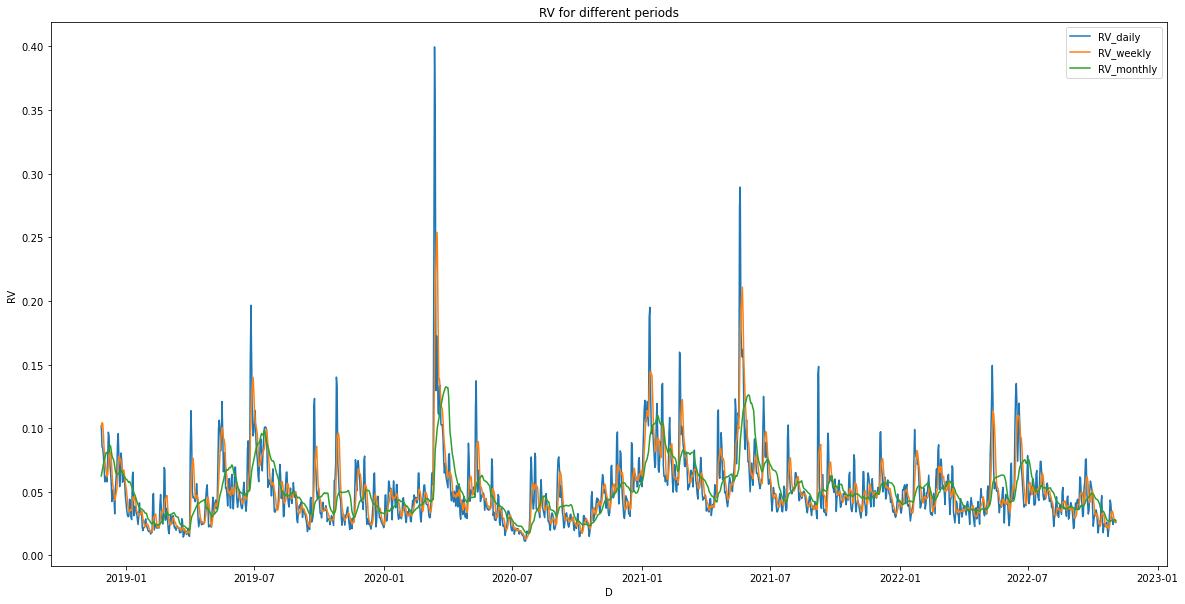

In [15]:
######### Plot the RV variables #############  
rv[["RV_daily","RV_weekly","RV_monthly"]].plot(title = "RV for different periods", figsize = (20, 10))
plt.ylabel("RV")
plt.show()

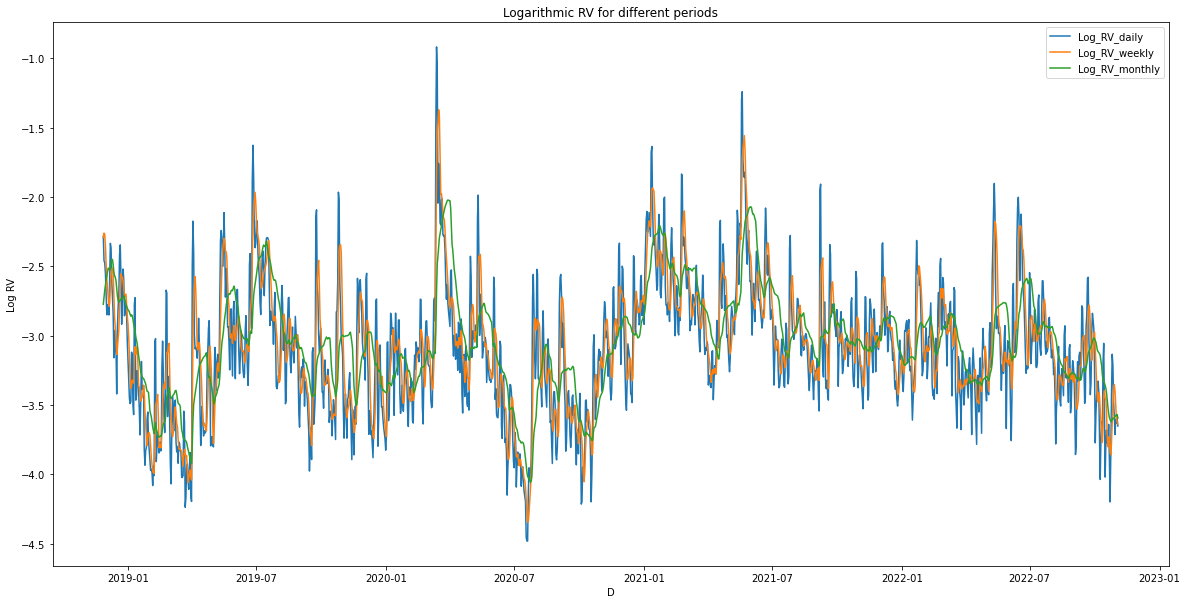

In [16]:
######### Plot the Log RV variables #############

rv[["Log_RV_daily","Log_RV_weekly","Log_RV_monthly"]].plot(title = "Logarithmic RV for different periods", figsize = (20, 10))
plt.ylabel("Log RV")
plt.show()

### Test and Train

In [17]:
####### Prepare data #########
rv.drop(["RV_daily", "RV_weekly", "RV_monthly", "sum_of_squares"], axis = 1, inplace = True)
rv["Target"] = rv["Log_RV_daily"].shift(-1) # I want to predict the RV of the next day.  
rv.dropna(inplace = True)

######### Scale the data #############
rv_scaled = (rv-rv.min())/(rv.max()-rv.min())

########### Add constant c #############
rv_scaled = sm.add_constant(rv_scaled)

######## #Split train and test sets ##########
split = int(0.60 * rv.shape[0])
X = rv_scaled.drop("Target", axis = 1)
y = rv_scaled[["Target"]]
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

### OLS regression

In [18]:
results = sm.OLS(y_train, X_train).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Target   R-squared:                       0.768
Model:                            OLS   Adj. R-squared:                  0.767
Method:                 Least Squares   F-statistic:                     946.5
Date:                Sun, 13 Nov 2022   Prob (F-statistic):          1.37e-271
Time:                        02:38:57   Log-Likelihood:                 1067.6
No. Observations:                 862   AIC:                            -2127.
Df Residuals:                     858   BIC:                            -2108.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0410      0.007      5.865      0.000       0.027       0.055
Log_RV_daily       0.8406      0.034     24.978      0.000       0.775       0.907
Log_RV_weekly     -0.0198      0.038     -0.523      0.601      -0.094       0.054
Log_RV_monthly     0.0555      0.020      2.710      0.007       0.015       0.096
==============================================================================
Omnibus:                      222.207   Durbin-Watson:                   1.568
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1044.191
Skew:                           1.106   Prob(JB):                    1.81e-227
Kurtosis:                       7.917   Cond. No.                         25.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

As we can see, $p-value$ for weekly logarithmic RV is very large, so there is no significance for this coefficient 

### Metrics and predictions

In [19]:
########### Perform out of sample prediction ############
y_hat = results.predict(X_test)

In [20]:
############# Metrics ###############
def score(y_hat, y, metric):
    """Return metrics of y_hat vs. y

    Args:
        y_hat (np.array): Predicted values
        y (np.array): Actual values
        metric (str): Metric to use

    Returns:
        float: The metric
    """
    if metric == "MSE": 
        return np.mean( (y_hat-y)**2)
    elif metric == "R_squared":
        ss_res = np.sum( (y - y_hat)**2 )
        ss_tot = np.sum( (y - np.average(y)) **2)
        return 1 - ss_res/ss_tot
    elif metric == "MAE":
        return np.mean( np.abs(y-y_hat))

In [21]:
######### In-sample scores ###########
print("In-sample scores")

y_hat_is = results.predict(X_train)
mse_is = score(y_hat_is, y_train.values.ravel(), "MSE")
r_sq_is = score(y_hat_is, y_train.values.ravel(), "R_squared")
mae_is = score(y_hat_is, y_train.values.ravel(), "MAE")

print(f"MSE:{mse_is}, R^2:{r_sq_is}, MAE:{mae_is}")      

print("----------------")
               
############## Out-of-sample scores #############
print("Out-of-sample scores")
               
mse_oos = score(y_hat, y_test.values.ravel(), "MSE")
r_sq_oos = score(y_hat, y_test.values.ravel(), "R_squared")
mae_oos = score(y_hat, y_test.values.ravel(), "MAE")

print(f"MSE:{mse_oos}, R^2:{r_sq_oos}, MAE:{mae_oos}")

In-sample scores
MSE:0.004918298502834503, R^2:0.7679606725672764, MAE:0.050308063099467934
----------------
Out-of-sample scores
MSE:0.004059329372295, R^2:0.6635190811159772, MAE:0.04556808796287606


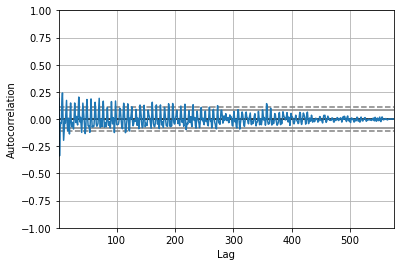

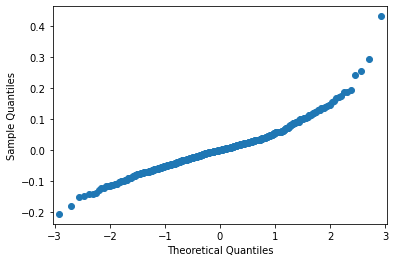

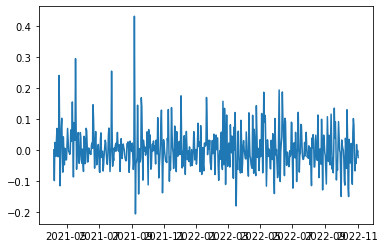

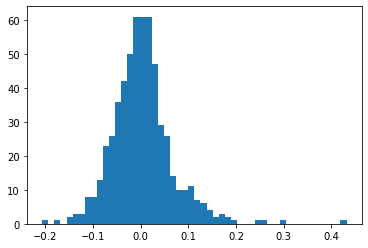

In [22]:
####### Residuals ############
residuals = y_test.values.ravel() - y_hat

autocorrelation_plot(residuals);plt.show()
qqplot(residuals);plt.show()
plt.plot(residuals);plt.show()
plt.hist(residuals, bins = 50); plt.show()